In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import math
from scipy import stats
import pickle
from causality.analysis.dataframe import CausalDataFrame
from sklearn.linear_model import LinearRegression
import datetime

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

Open the data from past notebooks and correct them to only include years that are common between the data structures (>1999).

In [4]:
with open('VariableData/money_data.pickle', 'rb') as f:
    income_data, housing_data, rent_data = pickle.load(f)
with open('VariableData/demographic_data.pickle', 'rb') as f:
    demographic_data = pickle.load(f)
with open('VariableData/endowment.pickle', 'rb') as f:
    endowment = pickle.load(f)
with open('VariableData/expander.pickle', 'rb') as f:
    expander = pickle.load(f)

In [5]:
endowment = endowment[endowment['FY'] > 1997].reset_index()
endowment.drop('index', axis=1, inplace=True)

demographic_data = demographic_data[demographic_data['year'] > 1999].reset_index()
demographic_data.drop('index', axis=1, inplace=True)

income_data = income_data[income_data['year'] > 1999].reset_index()
income_data.drop('index', axis=1, inplace=True)

housing_data = housing_data[housing_data['year'] > 1999].reset_index()
housing_data.drop('index', axis=1, inplace=True)

rent_data = rent_data[rent_data['year'] > 1999].reset_index()
rent_data.drop('index', axis=1, inplace=True)

Read in the data on Harvard owned land and Cambridge's property records. Restrict the Harvard data to Cambridge, MA.

In [6]:
harvard_land = pd.read_excel("Spreadsheets/2018_building_reference_list.xlsx", header=3)
harvard_land = harvard_land[harvard_land['City'] == 'Cambridge']

In [7]:
cambridge_property = pd.read_excel("Spreadsheets/cambridge_properties.xlsx")

Restrict the Cambridge data to Harvard properties, and only use relevant columns.

In [8]:
cambridge_property = cambridge_property[cambridge_property['Owner_Name'].isin(['PRESIDENT & FELLOWS OF HARVARD COLLEGE', 'PRESIDENT & FELLOW OF HARVARD COLLEGE'])]

In [9]:
cambridge_property = cambridge_property[['Address', 'PropertyClass', 'LandArea', 'BuildingValue', 'LandValue', 'AssessedValue', 'SalePrice', 'SaleDate', 'Owner_Name']]

Fix the time data.

In [10]:
cambridge_property['SaleDate'] = pd.to_datetime(cambridge_property['SaleDate'], infer_datetime_format=True)

In [11]:
clean_property = cambridge_property.drop_duplicates(subset=['Address'])

Only look at properties purchased after 2000.

In [12]:
#recent_property = clean_property[clean_property['SaleDate'] > datetime.date(2000, 1, 1)]
recent_property = clean_property[clean_property['SaleDate'] > np.datetime64('2000-01-01')]

In [13]:
property_numbers = recent_property[['LandArea', 'AssessedValue', 'SalePrice']]
num_recent = recent_property['Address'].count()
sum_properties = property_numbers.sum()

In [14]:
sum_properties

LandArea            289391
AssessedValue    115226500
SalePrice         57548900
dtype: int64

In [15]:
full_property_numbers = clean_property[['LandArea', 'AssessedValue', 'SalePrice']]
sum_full = full_property_numbers.sum()

In [16]:
delta_property = sum_properties / sum_full

In [17]:
delta_property

LandArea         0.029169
AssessedValue    0.017518
SalePrice        0.428483
dtype: float64

What can be gathered from above?

Since the year 2000, Harvard has increased its presence in Cambridge by about 3%, corresponding to about 2% of its overall assessed value, an increase of 281,219 square feet and \$115,226,500. Although the assessed value increase is so high, Harvard only paid \$57,548,900 for the property at their times of purchase.

To make some adjustments for inflation:

Note that the inflation rate since 2000 is ~37.8% (https://data.bls.gov/timeseries/CUUR0000SA0L1E?output_view=pct_12mths).

In [18]:
inflation_data = pd.read_excel("Spreadsheets/inflation.xlsx", header=11)
inflation_data = inflation_data[['Year', 'Jan']]
inflation_data['Year'] = pd.to_datetime(inflation_data['Year'], format='%Y')
inflation_data['CumulativeInflation'] = inflation_data['Jan'].cumsum()
inflation_data.rename(columns={'Year' : 'SaleDate'}, inplace=True)
recent_property['SaleDate'] = recent_property['SaleDate'].dt.year
inflation_data['SaleDate'] = inflation_data['SaleDate'].dt.year

/Users/hakeemangulu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [19]:
recent_property = pd.merge(recent_property, inflation_data, how="left", on=['SaleDate'])
recent_property = recent_property.drop('Jan', 1)

In [20]:
recent_property['TodaySale'] = (1 + (recent_property['CumulativeInflation'] / 100)) * recent_property['SalePrice']

In [21]:
today_sale_sum = recent_property['TodaySale'].sum()

In [22]:
today_sale_sum

65929240.0

In [23]:
sum_properties['AssessedValue'] - today_sale_sum

49297260.0

Hence, adjusted for inflation, the sale price of the property Harvard has acquired since 2000 is \$65,929,240.

The difference between this value and the assessed value of the property (in 2018) is: \$49,297,260, showing that Harvard's property has appreciated in value even more than (twice more than) inflation would account for, illustrating a clear advantageous dynamic for Harvard.

In [24]:
sorted_df = recent_property.sort_values(by=['SaleDate'])
sorted_df = sorted_df.reset_index().drop('index', 1)
sorted_df['CumLand'] = sorted_df['LandArea'].cumsum()
sorted_df['CumValue'] = sorted_df['AssessedValue'].cumsum()
sorted_df

,Address,PropertyClass,LandArea,BuildingValue,LandValue,AssessedValue,SalePrice,SaleDate,Owner_Name,CumulativeInflation,TodaySale,CumLand,CumValue
0,113 Walker St,SNGL-FAM-RES,9121,2973800,1740000,4713800,1600000,2000,PRESIDENT & FELLOWS OF HARVARD COLLEGE,2.0,1632000.0,9121,4713800
1,100 Land Blvd,"Private College, University",65683,43883200,19941400,63824600,100,2002,PRESIDENT & FELLOWS OF HARVARD COLLEGE,7.2,107.2,74804,68538400
2,24 Blackstone St,"Private College, University",109943,3784300,8000000,11784300,14118000,2003,PRESIDENT & FELLOWS OF HARVARD COLLEGE,9.1,15402738.0,184747,80322700
3,45 Blackstone St,CONDO-BLDG,43988,0,0,0,14118000,2003,PRESIDENT & FELLOWS OF HARVARD COLLEGE,9.1,15402738.0,228735,80322700
4,153 Mt Auburn St,"Private College, University",10233,1228800,484700,1713500,0,2003,PRESIDENT & FELLOWS OF HARVARD COLLEGE,9.1,0.0,238968,82036200
5,0 Arrow St,"Private College, University",0,8753600,0,8753600,5700000,2004,PRESIDENT & FELLOWS OF HARVARD COLLEGE,10.2,6281400.0,238968,90789800
6,20 Sumner Rd,"Private College, University",8184,607000,1152400,1759400,1288000,2010,PRESIDENT & FELLOWS OF HARVARD COLLEGE,23.1,1585528.0,247152,92549200
7,40 Kirkland St,"Private College, University",8172,1404300,1150800,2555100,4112400,2010,PRESIDENT & FELLOW OF HARVARD COLLEGE,23.1,5062364.4,255324,95104300
8,42 Kirkland St,"Private College, University",10518,1564400,925600,2490000,4112400,2010,PRESIDENT & FELLOWS OF HARVARD COLLEGE,23.1,5062364.4,265842,97594300
9,9 Ash St,SNGL-FAM-RES,4800,303200,1426200,1729400,1250000,2010,PRESIDENT & FELLOWS OF HARVARD COLLEGE,23.1,1538750.0,270642,99323700


Graph the results.

In [25]:
def fitter(x, y, regr_x):
    """
    Use linear regression to make a best fit line for a set of data.
    Args:
        x (numpy array): The independent variable.
        y (numpy array): The dependent variable.
        regr_x (numpy array): The array used to extrapolate the regression.
    """
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return (slope * regr_x + intercept)

In [26]:
years = sorted_df['SaleDate'].as_matrix()
cum_land = sorted_df['CumLand'].as_matrix()
cum_value = sorted_df['CumValue'].as_matrix()
regr = np.arange(2000, 2012)

line0 = fitter(years, cum_land, regr)

trace0 = go.Scatter(
            x = years,
            y = cum_land,
            mode = 'markers',
            name='Harvard Land\n In Cambridge',
            marker=go.Marker(color='#601014')
        )
fit0 = go.Scatter(
                  x = regr,
                  y = line0,
                  mode='lines',
                  marker=go.Marker(color='#D2232A'),
                  name='Fit'
                  )

data = [trace0, fit0]

layout = go.Layout(
            title = "The Change In Harvard's Land in Cambridge Since 2000",
            font = dict(family='Gotham', size=18),
            yaxis=dict(
                title='Land Accumulated Since 2000 (Sq. Feet)'
            ),
            xaxis=dict(
                title='Year')
        )

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename="land_changes")

/Users/hakeemangulu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/Users/hakeemangulu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/Users/hakeemangulu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/Users/hakeemangulu/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:426: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




In [27]:
graph2_df = pd.DataFrame(list(zip(regr, line0)))
graph2_df.to_csv('graph2.csv')

In [28]:
def grapher(x, y, city, title, ytitle, xtitle, filename):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    fit = slope * x + intercept

    trace0 = go.Scatter(
                x = x,
                y = y,
                mode = 'markers',
                name=city,
                marker=go.Marker(color='#D2232A')
            )
    fit0 = go.Scatter(
                      x = x,
                      y = fit,
                      mode='lines',
                      marker=go.Marker(color='#AC1D23'),
                      name='Linear Fit'
                      )

    data = [trace0, fit0]

    layout = go.Layout(
                title = title,
                font = dict(family='Gotham', size=12),
                yaxis=dict(
                    title=ytitle
                ),
                xaxis=dict(
                    title=xtitle)
            )

    fig = go.Figure(data=data, layout=layout)
    return iplot(fig, filename=filename)

In [64]:
len(line0)

12

Restrict the demographic data to certain years (up to 2012) in order to fit the data well.

In [65]:
demographic_data = demographic_data[demographic_data['year'] < 2011]
rent_data = rent_data[rent_data['year'] < 2011]
housing_data = housing_data[housing_data['year'] < 2011]
x = cum_land
y = pd.to_numeric(demographic_data['c_black']).as_matrix()
z1 = pd.to_numeric(rent_data['cambridge']).as_matrix()
z2 = pd.to_numeric(housing_data['cambridge']).as_matrix()

/Users/hakeemangulu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/Users/hakeemangulu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/Users/hakeemangulu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [66]:
endow_black = grapher(x, y, "Cambridge", "The Correlation Between Harvard Land Change and Black Population", "Black Population of Cambridge", "Land Change (Sq. Feet)", "land_black")

/Users/hakeemangulu/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:426: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




In [67]:
plt.rcParams['font.size'] = 10
gotham_black = fm.FontProperties(fname='/Users/hakeemangulu/Library/Fonts/Gotham Black Regular.ttf')
gotham_book = fm.FontProperties(fname='/Users/hakeemangulu/Library/Fonts/Gotham Book Regular.otf')

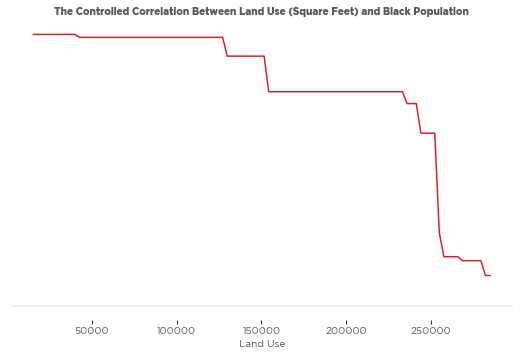

In [89]:
X  = CausalDataFrame({'x': x, 'y': y, 'z1': z1, 'z2': z2})
causal_land_black = X.zplot(x='x', y='y', z=['z1', 'z2'], z_types={'z1': 'c', 'z2': 'c'}, kind='line', color="#D2232A")

fig = causal_land_black.get_figure()
fig.set_size_inches(9, 5.5)
ax = plt.gca()
ax.set_frame_on(False)
ax.get_yaxis().set_visible(False)
ax.legend_.remove()
plt.axhline(y=12200, linewidth=0.2, color='#595959')

ax.set_title("The Controlled Correlation Between Land Use (Square Feet) and Black Population", fontproperties=gotham_black, size=10, color="#595959")
ax.set_xlabel("Land Use", fontproperties=gotham_book, fontsize=10, color="#595959")
for tick in ax.get_xticklabels():
    tick.set_fontproperties(gotham_book)
    tick.set_fontsize(10)
    tick.set_color("#595959")
    
fig.savefig('images/black_land.svg', format='svg', dpi=2400, bbox_inches='tight')

In [91]:
graph9_df = pd.DataFrame(X)
graph9_df.to_csv('graph9.csv')

/Users/hakeemangulu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/Users/hakeemangulu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



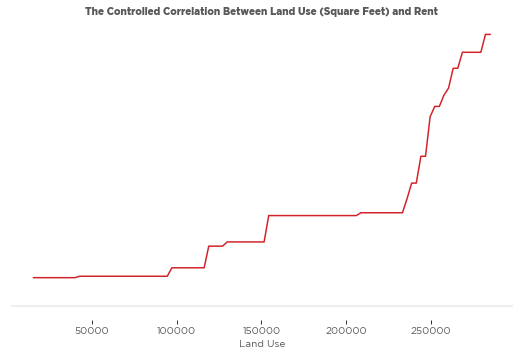

In [108]:
y = pd.to_numeric(rent_data['cambridge']).as_matrix()
z1 = pd.to_numeric(housing_data['cambridge']).as_matrix()

X  = CausalDataFrame({'x': x, 'y': y, 'z1': z1})
causal_land_rent = X.zplot(x='x', y='y', z=['z1'], z_types={'z1': 'c'}, kind='line', color="#D2232A")
fig = causal_land_rent.get_figure()
fig.set_size_inches(9, 5.5)

ax = plt.gca()
ax.set_frame_on(False)
ax.get_yaxis().set_visible(False)
ax.legend_.remove()
plt.axhline(y=1350, linewidth=0.2, color='#595959')

ax.set_title("The Controlled Correlation Between Land Use (Square Feet) and Rent", fontproperties=gotham_black, size=10, color="#595959")
ax.set_xlabel("Land Use", fontproperties=gotham_book, fontsize=10, color="#595959")
for tick in ax.get_xticklabels():
    tick.set_fontproperties(gotham_book)
    tick.set_fontsize(10)
    tick.set_color("#595959")
    
fig.savefig('images/rent_land.svg', format='svg', dpi=1200, bbox_inches='tight')